# Imports, Device

In [1]:
!pwd

/home/shatz/adv_deep_learning


In [2]:
%matplotlib inline
#from tqdm import tqdm
from tqdm.notebook import tqdm

import torchvision
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import transforms
from torchvision.datasets.utils import download_url
import os
import tarfile
import hashlib
import numpy as np
import queue

import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [4]:
device

device(type='cuda')

# ⬇️ Download Dataset

Most of this is copied from Tutorial 4

In [5]:
# https://github.com/fastai/imagenette
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz'
dataset_filename = dataset_url.split('/')[-1]
dataset_foldername = dataset_filename.split('.')[0]
data_path = './data'
dataset_filepath = os.path.join(data_path,dataset_filename)
dataset_folderpath = os.path.join(data_path,dataset_foldername)

os.makedirs(data_path, exist_ok=True)

download = False
if not os.path.exists(dataset_filepath):
    download = True
else:
    md5_hash = hashlib.md5()


    file = open(dataset_filepath, "rb")

    content = file.read()

    md5_hash.update(content)


    digest = md5_hash.hexdigest()
    if digest != 'fe2fc210e6bb7c5664d602c3cd71e612':
        download = True
if download:
    download_url(dataset_url, data_path)

with tarfile.open(dataset_filepath, 'r:gz') as tar:
    tar.extractall(path=data_path)

In [6]:
class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]

    def __repr__(self):
        format_string = self.__class__.__name__ + '(\n\t'
        format_string += self.base_transform.__repr__().replace('\n', '\n\t')
        format_string += '\n)'
        return format_string

Make Datasets

In [7]:
size  = 224
ks = (int(0.1 * size) // 2) * 2 + 1 # should be odd
__imagenet_stats = {'mean': [0.485, 0.456, 0.406],
                    'std': [0.229, 0.224, 0.225]}

train_transform = TwoCropsTransform(transforms.Compose([transforms.RandomResizedCrop(scale=(0.2, 1), size=size),
                                      transforms.RandomHorizontalFlip(),
                                      # transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
                                      transforms.RandomGrayscale(p=0.2),
                                      # transforms.GaussianBlur(kernel_size=ks),
                                      transforms.ToTensor(),
                                      transforms.Normalize(**__imagenet_stats)
                                    ]))

val_tfms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(**__imagenet_stats)
    ])
downstream_train_trainsform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(**__imagenet_stats)
                                           ])

train_folder_dir = os.path.join(dataset_folderpath,'train')
val_folder_dir = os.path.join(dataset_folderpath,'val')
train_dataset = torchvision.datasets.ImageFolder(train_folder_dir, train_transform)
val_dataset = torchvision.datasets.ImageFolder(val_folder_dir, val_tfms)
downstream_train_dataset = torchvision.datasets.ImageFolder(train_folder_dir, downstream_train_trainsform)

Dataloaders

In [8]:
batch_size = 64

In [9]:
train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=6,
        drop_last=True,
        shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=6,
    shuffle=True
)
downstream_train_dataloader = torch.utils.data.DataLoader(
    downstream_train_dataset,
    batch_size=batch_size,
    num_workers=6,
    shuffle=True
)

In [10]:
train_dataset.classes

['n01440764',
 'n02102040',
 'n02979186',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n03425413',
 'n03445777',
 'n03888257']

In [11]:
def get_numpy_samples(inputs):
        mean = torch.as_tensor(__imagenet_stats['mean'], dtype=inputs.dtype, device=inputs.device)
        std = torch.as_tensor(__imagenet_stats['std'], dtype=inputs.dtype, device=inputs.device)
        inputs = inputs * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)
        inputs = inputs.numpy()
        inputs = np.transpose(inputs, (0,2,3,1))
        return inputs

In [12]:
# fig, axes = plt.subplots(nrows=batch_size, ncols=2, figsize=(10,100))
# for (input1, input2), _ in train_dataloader:
#     np_inputs1, np_inputs2 = get_numpy_samples(input1), get_numpy_samples(input2)
#     for row in range(batch_size):
#         axes[row, 0].axis("off")
#         axes[row, 0].imshow(np_inputs1[row])
#         axes[row, 1].axis("off")
#         axes[row, 1].imshow(np_inputs2[row])
#     break
# plt.show()

In [13]:
# from: https://gist.github.com/weiaicunzai/2a5ae6eac6712c70bde0630f3e76b77b
def accuracy(output: torch.Tensor, target: torch.Tensor, topk=(1,)) -> list[torch.FloatTensor]:
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-5 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.

    ref:
    - https://pytorch.org/docs/stable/generated/torch.topk.html
    - https://discuss.pytorch.org/t/imagenet-example-accuracy-calculation/7840
    - https://gist.github.com/weiaicunzai/2a5ae6eac6712c70bde0630f3e76b77b
    - https://discuss.pytorch.org/t/top-k-error-calculation/48815/2
    - https://stackoverflow.com/questions/59474987/how-to-get-top-k-accuracy-in-semantic-segmentation-using-pytorch

    :param output: output is the prediction of the model e.g. scores, logits, raw y_pred before normalization or getting classes
    :param target: target is the truth (as a vector of indecies)
    :param topk: tuple of topk's to compute e.g. (1, 2, 5) computes top 1, top 2 and top 5.
    e.g. in top 2 it means you get a +1 if your models's top 2 predictions are in the right label.
    So if your model predicts cat, dog (0, 1) and the true label was bird (3) you get zero
    but if it were either cat or dog you'd accumulate +1 for that example.
    :return: list of topk accuracy [top1st, top2nd, ...] depending on your topk input
    """
    with torch.no_grad():
        # ---- get the topk most likely labels according to your model
        # get the largest k \in [n_classes] (i.e. the number of most likely probabilities we will use)
        maxk = max(topk)  # max number labels we will consider in the right choices for out model
        batch_size = target.size(0)

        # get top maxk indicies that correspond to the most likely probability scores
        # (note _ means we don't care about the actual top maxk scores just their corresponding indicies/labels)
        _, y_pred = output.topk(k=maxk, dim=1)  # _, [B, n_classes] -> [B, maxk]
        y_pred = y_pred.t()  # [B, maxk] -> [maxk, B] Expects input to be <= 2-D tensor and transposes dimensions 0 and 1.

        # - get the credit for each example if the models predictions is in maxk values (main crux of code)
        # for any example, the model will get credit if it's prediction matches the ground truth
        # for each example we compare if the model's best prediction matches the truth. If yes we get an entry of 1.
        # if the k'th top answer of the model matches the truth we get 1.
        # Note: this for any example in batch we can only ever get 1 match (so we never overestimate accuracy <1)
        target_reshaped = target.view(1, -1).expand_as(y_pred)  # [B] -> [B, 1] -> [maxk, B]
        # compare every topk's model prediction with the ground truth & give credit if any matches the ground truth
        correct = (y_pred == target_reshaped)  # [maxk, B] were for each example we know which topk prediction matched truth
        # original: correct = pred.eq(target.view(1, -1).expand_as(pred))

        # -- get topk accuracy
        list_topk_accs = []  # idx is topk1, topk2, ... etc
        for k in topk:
            # get tensor of which topk answer was right
            ind_which_topk_matched_truth = correct[:k]  # [maxk, B] -> [k, B]
            # flatten it to help compute if we got it correct for each example in batch
            flattened_indicator_which_topk_matched_truth = ind_which_topk_matched_truth.reshape(-1).float()  # [k, B] -> [kB]
            # get if we got it right for any of our top k prediction for each example in batch
            tot_correct_topk = flattened_indicator_which_topk_matched_truth.float().sum(dim=0, keepdim=True)  # [kB] -> [1]
            # compute topk accuracy - the accuracy of the mode's ability to get it right within it's top k guesses/preds
            topk_acc = tot_correct_topk / batch_size  # topk accuracy for entire batch
            list_topk_accs.append(topk_acc)
        return list_topk_accs  # list of topk accuracies for entire batch [topk1, topk2, ... etc]


# 🧪 MOCO

In [14]:
class MOCOv2(nn.Module):
    def __init__(self, base_network_q, base_network_k, C, K, t, m, device):
        super().__init__()
        self.f_q = base_network_q # query encoder
        self.f_q.fc = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.ReLU(),
            self.f_q.fc
        )
        
        self.f_k = base_network_k # key encoder
        self.f_k.fc = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.ReLU(),
            self.f_k.fc
        )
        for p in self.f_k.parameters():
            p.requires_grad = False
            
        self.queue = torch.randn((C, K)).to(device) # holds minibatches (features)
        self.t = t
        self.m = m
        self.device = device
    
    def forward(self, x_q, x_k):
        q = self.f_q(x_q) # queries
        k = self.f_k(x_k) # keys
        k = k.detach() # no gradient to keys
        return q, k
    
    def loss(self, q, k):
        N = q.shape[0]
        
        # positive logits: Nx1
        # unsqueezing is the same as view() in the paper
        l_pos = torch.bmm(q.unsqueeze(1), k.unsqueeze(-1)).squeeze(-1) # Nx1
        l_neg = torch.mm(q, self.queue) # NxC * CxK = NxK
        
        # cat([Nx1, NxK]) = Nx(K+1)
        logits = torch.cat([l_pos, l_neg], dim=1)
        
        labels = torch.zeros(N).type(torch.LongTensor).to(device)
        
        loss = nn.CrossEntropyLoss()(logits/self.t, labels)
        
        return loss
        
    def momentum_update(self):
        ''' 
        Updates f_k with momentum update.
        Do this only after updating f_q 
        '''
        with torch.no_grad():
            for (p_k, p_q) in zip(self.f_k.parameters(), self.f_q.parameters()):
                new_param_value = self.m * p_k.data + (1-self.m) * p_q.data
                p_k.copy_(new_param_value)

        
    def update_queue(self, k):
        # queue is NxK
        # need to roll by batch size, then replace with curr batch
        
        # k.t() is CxN
        batch_size = k.shape[0] # N
        
        self.queue = self.queue.roll(batch_size, 1)
        self.queue[:, :batch_size] = k.t()
        
        

# 🏋️‍♂️ Train

In [15]:
### Hyperparams ###

epochs = 2000

K = 1280 # number of keys in dict
C = 128 # feature dim
t = 0.02 # temperature
m = 0.99 # momentum (for updating key encoder)

In [16]:
print('ok')

ok


In [17]:
enc_q = torchvision.models.resnet50(num_classes=C, pretrained=False)
enc_k = torchvision.models.resnet50(num_classes=C, pretrained=False)

In [18]:
moco = MOCOv2(base_network_q=enc_q, base_network_k=enc_k, C=C, K=K, t=t, m=m, device=device).to(device)

In [19]:
optimizer = torch.optim.Adam(moco.f_q.parameters(), lr=3e-5)

In [ ]:
avg_losses = []
for e in range(epochs):
    tqdm.write('Epoch {}'.format(e))
    train_losses = []
    for (i, ((x_q, x_k), _)) in enumerate(tqdm(train_dataloader)):

        x_q, x_k = x_q.to(device), x_k.to(device)
        
        optimizer.zero_grad()

        q, k = moco(x_q, x_k)

        loss = moco.loss(q, k)

        loss.backward()
        optimizer.step()

        moco.momentum_update()

        moco.update_queue(k)

        train_losses.append(loss.item())
            
        
    avg_loss = sum(train_losses) / len(train_losses)
    avg_losses.append(avg_loss)
    tqdm.write('avg_loss: {}'.format(avg_loss))
    
    ## save best epoch, only check after 10 epochs
    if e > 3:
        curr_loss = avg_losses[-1]
        prev_losses = avg_losses[:-1]
        if curr_loss < min(prev_losses):
            torch.save(moco.f_q.state_dict(), 'models_moco2/best_resnet34.pth')
            print('saved')
    
    ## also save every 10 epochs
    if e%10 == 0:
        torch.save(moco.f_q.state_dict(), 'models_moco2/resnet34_ep{}.pth'.format(e))
        
    with open('losses_r50.txt', 'a') as filehandle:
        filehandle.writelines("epoch {}: {}".format(e, avg_losses[-1]))
    
    

Epoch 0


  0%|          | 0/147 [00:00<?, ?it/s]

avg_loss: 33.75004461833409
Epoch 1


  0%|          | 0/147 [00:00<?, ?it/s]

avg_loss: 44.2511738525618
Epoch 2


  0%|          | 0/147 [00:00<?, ?it/s]

avg_loss: 924.7051021614853
Epoch 3


  0%|          | 0/147 [00:00<?, ?it/s]

avg_loss: 3073.925229027158
Epoch 4


  0%|          | 0/147 [00:00<?, ?it/s]

In [ ]:
avg_losses

In [ ]:
plt.plot(np.arange(len(avg_losses)), avg_losses)
plt.savefig('losses.png')

# 🏞 Downstream Task

### Prepare Model

In [60]:
backbone = torchvision.models.resnet34(num_classes=C, pretrained=False)
# backbone = torchvision.models.vgg19(num_classes=C, pretrained=False)
backbone.load_state_dict(torch.load('FIXED30.pth'))

<All keys matched successfully>

In [61]:
# backbone = moco.f_q

In [62]:
# freeze feature extractor
for param in backbone.parameters():
    param.requires_grad = False

In [63]:
# add another layer
backbone = nn.Sequential(
    backbone, 
    nn.Linear(128, len(downstream_train_dataset.classes)),
).to(device)

In [64]:
# OR replace last layer
# backbone.fc = nn.Linear(512, len(downstream_train_dataset.classes)).to(device)

In [65]:
downstream_optimizer = torch.optim.Adam(backbone.parameters(), lr=1e-4)

### Train Linear Layer

In [66]:
downstream_epochs = 15

In [67]:
# val_dataloader_iterator = iter(val_dataloader)

In [68]:
top_1_accs = []
top_5_accs = []
val_losses = []
train_losses = []
for epoch in range(downstream_epochs):
    print('\nepoch {}'.format(epoch))
    val_loss = 0
    train_loss = 0
    correct = 0
    top_1_acc = 0
    top_5_acc = 0
    for i, (x, y) in enumerate(tqdm(downstream_train_dataloader)):

        x = x.to(device)
        y = y.to(device)


        downstream_optimizer.zero_grad()
        out = backbone(x)
        loss = F.cross_entropy(out, y)
        loss.backward()
        downstream_optimizer.step()
        train_loss += loss.item()

    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(val_dataloader)):
            x, y = x.to(device), y.to(device)
            out = backbone(x)
            loss = F.cross_entropy(out, y)
            accs = accuracy(out, y, topk=(1, 5))
            top_1_acc += accs[0].item()
            top_5_acc += accs[1].item()
            val_loss += loss.item()
                
    tqdm.write('train_loss: {}'.format(train_loss))
    tqdm.write('val_loss:   {}'.format(val_loss))
    tqdm.write('top1: {}'.format(top_1_acc / len(val_dataloader)))
    tqdm.write('top5: {}'.format(top_5_acc / len(val_dataloader)))
    val_losses.append(val_loss)
    train_losses.append(train_loss)
    top_1_accs.append(top_1_acc / len(val_dataloader))
    top_5_accs.append(top_5_acc / len(val_dataloader))


epoch 0


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 340.8825466632843
val_loss:   142.55909061431885
top1: 0.1114391321616788
top5: 0.5238455264799057

epoch 1


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 339.9339699745178
val_loss:   142.21752333641052
top1: 0.1476934523952584
top5: 0.6016825077033812

epoch 2


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 339.08214569091797
val_loss:   141.89322519302368
top1: 0.18554387481943255
top5: 0.6538858490605508

epoch 3


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 338.26172709465027
val_loss:   141.541428565979
top1: 0.21476574506490462
top5: 0.6798555110731432

epoch 4


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 337.45476770401
val_loss:   141.24313044548035
top1: 0.23922331030330352
top5: 0.6919522852666916

epoch 5


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 336.78524827957153
val_loss:   140.90605926513672
top1: 0.265216974000777
top5: 0.7040610601825099

epoch 6


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 335.9752628803253
val_loss:   140.6130347251892
top1: 0.27854982739494694
top5: 0.7156177999511841

epoch 7


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 335.33216762542725
val_loss:   140.28791618347168
top1: 0.29413882498779603
top5: 0.7201900924405744

epoch 8


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 334.498464345932
val_loss:   139.9782166481018
top1: 0.29517089094846477
top5: 0.7317828343760583

epoch 9


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 333.78666710853577
val_loss:   139.6588888168335
top1: 0.309331797303692
top5: 0.7383832566199764

epoch 10


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 333.10715222358704
val_loss:   139.35854816436768
top1: 0.3151041668268942
top5: 0.7406153996144572

epoch 11


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 332.46865797042847
val_loss:   139.06589555740356
top1: 0.32015649012980923
top5: 0.7489199311502518

epoch 12


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 331.7141373157501
val_loss:   138.80952405929565
top1: 0.32010848700038846
top5: 0.7536962368795949

epoch 13


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 331.00176644325256
val_loss:   138.48455095291138
top1: 0.3244407643233576
top5: 0.7494239634083163

epoch 14


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 330.4180951118469
val_loss:   138.24719166755676
top1: 0.3198684715936261
top5: 0.7587245587379702


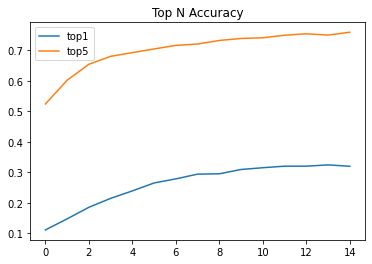

In [69]:
plt.plot(list(range(len(top_1_accs))), top_1_accs, label='top1')
plt.plot(list(range(len(top_5_accs))), top_5_accs, label='top5')
plt.legend()
plt.title('Top N Accuracy')
plt.show()

Text(0.5, 1.0, 'Train losses')

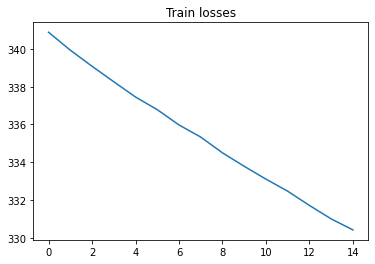

In [70]:
train_losses = np.asarray(train_losses)
plt.plot(list(range(len(train_losses))), train_losses)
# plt.plot(list(range(len(train_losses))), train_losses / len(train_dataset))
plt.title('Train losses')

Text(0.5, 1.0, 'Val losses')

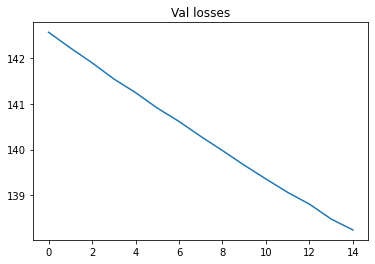

In [71]:
val_losses = np.asarray(val_losses)
plt.plot(list(range(len(val_losses))), val_losses)
# plt.plot(list(range(len(val_losses))), val_losses / len(val_dataset))
plt.title('Val losses')

Save Trained Backbone

In [35]:
torch.save(backbone.state_dict(), 're-trained_backbone.pth')

# 📊 Evaluate

In [36]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

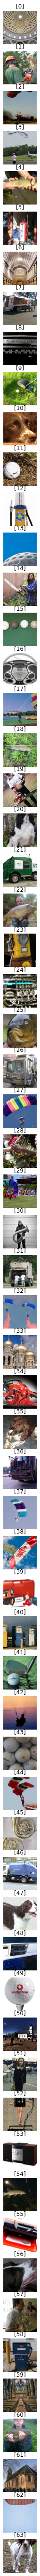

In [37]:
fig, axes = plt.subplots(nrows=batch_size, ncols=1, figsize=(10,100))
for (input1, label) in val_dataloader:
    np_inputs1 = get_numpy_samples(input1)
    for row in range(batch_size):
        axes[row].axis("off")
        axes[row].set_title([row])
        axes[row].imshow(np_inputs1[row])
#         axes[row, 1].axis("off")
#         axes[row, 1].imshow(np_inputs2[row])
    break
plt.show()

In [38]:
# for i, (x, y) in enumerate(val_dataloader):
    
#     x = get_numpy_samples(x)
#     plt.imshow(x)
    
#     if i > 3:
#         break